# Library calls

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as  plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,Flatten,InputLayer,Input
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import ResNet152V2,DenseNet121,InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy,TruePositives,TrueNegatives,FalseNegatives,FalsePositives
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score

# Load the dataset

In [ ]:
directory = '/content/drive/MyDrive/Test_dataset/brain_tumor_dataset'

In [ ]:
class_names = ['no','yes']

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=None,
    image_size=(256, 256),
    shuffle=True,
    seed=42
)

Found 253 files belonging to 2 classes.


# Data preprocessing

## splits

In [ ]:
def splits(dataset,Train_ratio,Val_ratio,Test_ratio):

    data_size = len(dataset)

    train_dataset = dataset.take(int(data_size*Train_ratio))

    val_split_set = dataset.skip(int(data_size*Train_ratio))

    val_dataset = val_split_set.take((int(data_size*Val_ratio)))

    test_dataset = val_split_set.skip(int(data_size*Test_ratio))
    return train_dataset,val_dataset,test_dataset

Train_ratio = 0.80
Val_ratio = .10
Test_ratio = 0.10
train_dataset,val_dataset,test_dataset  = splits(dataset,Train_ratio,Val_ratio,Test_ratio)

print("The length of the train_dataset is  : ",len(train_dataset))
print('The length of the val_dataset is  : ',len(val_dataset))
print('The length of the test_dataset is  : ',len(test_dataset))


The length of the train_dataset is  :  202
The length of the val_dataset is  :  25
The length of the test_dataset is  :  26


## visualize some image

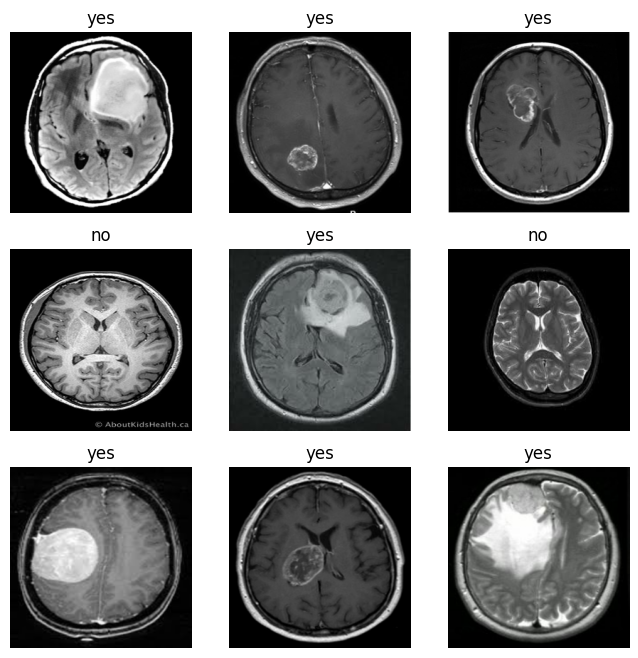

In [ ]:
plt.figure(figsize=(8,8))
for i,(image,label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image/255)
    plt.title(class_names[label])
    plt.axis('off')

## Dataset prepraration

In [ ]:
#  resize and rescaling

def resize_rescaling(image,label):

    return tf.image.resize(image,(224,224))/255,label

In [ ]:
train_dataset = (
             train_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(10)
            .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
             val_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(3)
            .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
test_dataset = (
             test_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE)
)

# Create  a model

In [ ]:
resnet_backbone = ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape= (224,224,3)
)
inputs = Input(shape=(224,224,3))
x = resnet_backbone(inputs)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1,activation='sigmoid')(x)
Resnet_model = Model(inputs,outputs,name='Resnet_model')
Resnet_model.compile(loss = BinaryCrossentropy(),
                   optimizer=Adam(learning_rate=0.0001),
                   metrics = ['accuracy'])
Resnet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=25,
                          verbose=1

                         )

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.6590 - loss: 0.7243 - val_accuracy: 0.4800 - val_loss: 2.1917
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.8658 - loss: 0.3185 - val_accuracy: 0.7600 - val_loss: 0.9368
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.9282 - loss: 0.2372 - val_accuracy: 0.8000 - val_loss: 0.6299
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.9648 - loss: 0.1489 - val_accuracy: 0.8400 - val_loss: 0.4344
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.9648 - loss: 0.1247 - val_accuracy: 0.8800 - val_loss: 0.3439
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - accuracy: 0.9694 - loss: 0.1063 - val_accuracy: 0.9600 - val_loss: 0.1531
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - accuracy: 0.9527 - loss: 0.1629 - val_accuracy: 0.9200 - val_loss: 0.2383
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/ste

## Evaluate the model

In [ ]:
def evaluate_model(model,dataset):

    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    accuracy = model.history.history['accuracy']
    val_accuracy = model.history.history['val_accuracy']

    plt.figure(figsize=(14,12))

    # Plot model loss
    plt.subplot(2,2,1)

    plt.plot(val_loss)
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend(['train_loss','val_loss'])
    plt.grid()

    # Plot model accuracy
    plt.subplot(2,2,2)

    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.grid()

    # confusion matrix
    plt.subplot(2,2,3)

    img = []
    labels = []
    for x,y in dataset:
        img.append(x)
        labels.append(y)
    true_label = np.array(labels).flatten()
    predicted = model.predict(np.array(img)[:,0,...])[:,0]

    threshold = 0.5

    cm = confusion_matrix(true_label, predicted > threshold)



    sns.heatmap(cm, annot=True,cmap='Blues',xticklabels=['NO','YES'],yticklabels=['NO','YES'])
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Plot roc curve
    plt.subplot(2,2,4)

    fp, tp, thresholds = roc_curve(true_label, predicted)
    roc_auc = roc_auc_score(true_label,predicted)
    plt.plot(fp,tp, color='blue',  label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")

    plt.grid()

    skip = 2

    for i in range(0, len(thresholds), skip):
      plt.text(fp[i], tp[i], thresholds[i])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

## ResNet152V2

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


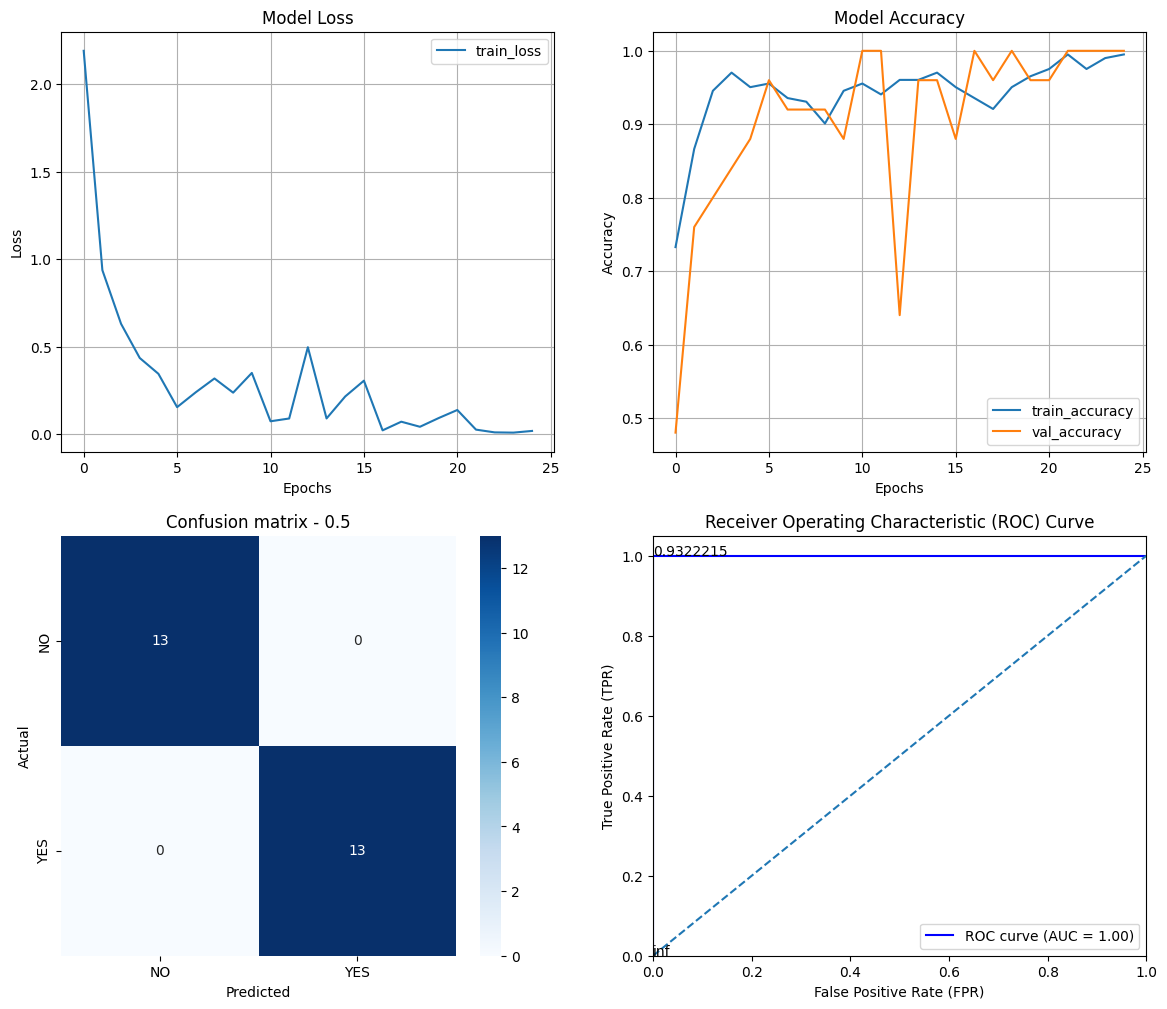

In [ ]:
evaluate_model(Resnet_model,test_dataset)

# Test the a model

## single prediction

In [ ]:
def Tumor_or_Not(x):
    if x<.5:
        return str('no')
    else:
        return str('yes')

In [ ]:
image = cv2.resize(cv2.imread('/content/drive/MyDrive/Test_dataset/brain_tumor_dataset/yes/Y101.jpg'),(224,224))
im   = tf.expand_dims(image,axis=0)
pred = Resnet_model.predict(im)[0][0]
print(Tumor_or_Not(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
yes


## multiple prediction with visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


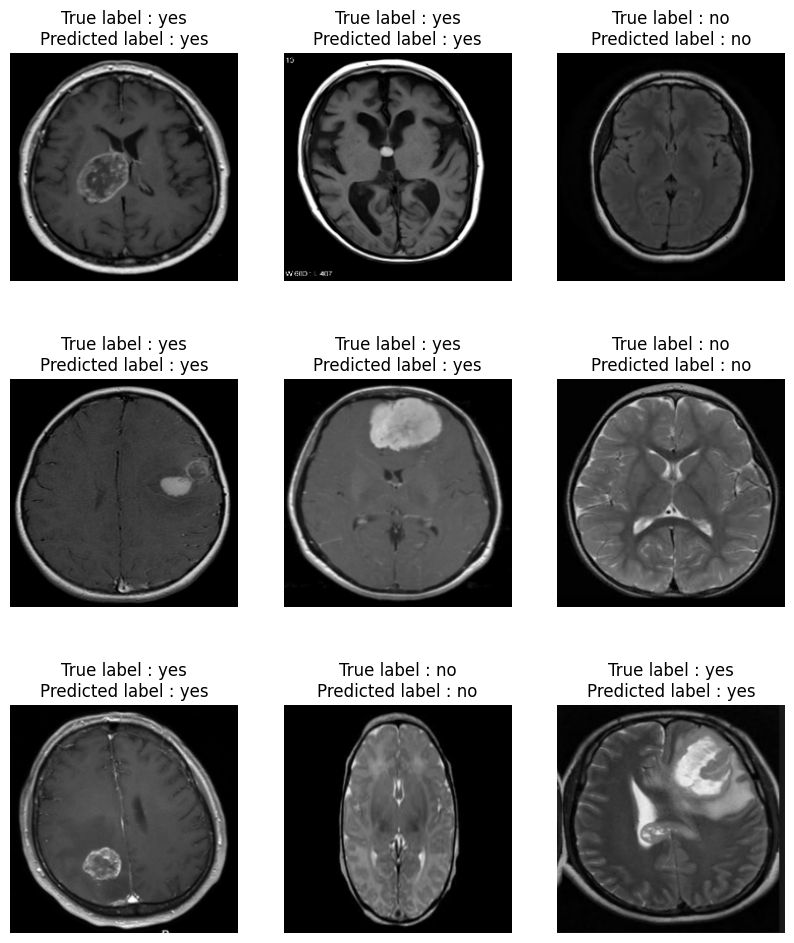

In [ ]:
plt.figure(figsize=(10,12))
for i,(image,label) in  enumerate(test_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title('True label : '+class_names[label[0]]+"\n"+'Predicted label : '+
             Tumor_or_Not(Resnet_model.predict(tf.expand_dims(image[0],axis=0))[0][0]))
    plt.axis('off')